In [1]:
from h5glance import H5Glance

import os
import sys
import h5py
import math
import numpy  as np
import pandas as pd

from scipy import stats

from lgdo import LH5Store #If this fails, try pip install legend-pydataobj
import lgdo.lh5_store as lh5

import matplotlib.pyplot as plt

from collections import namedtuple

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('/Users/romoluque_c/Repositories/BACON_romo/')
sys.path.append(repository_path)

import fit_functions as fitf

In [3]:
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"]      = 12

In [4]:
dsp_path = "/Users/romoluque_c/LEGEND/BSM_LEGEND/low_energy/data_p06/dsp/"

In [5]:
H5Glance(dsp_path + '/cal/r006/l200-p06-r006-cal-20230724T101824Z.lh5')

/Users/romoluque_c/LEGEND/BSM_LEGEND/low_energy/data_p06/dsp//cal/r006/l200-p06-r006-cal-20230724T101824Z.lh5/

In [6]:
def load_all_dsps(dir_dsp, channel, label='dsp'):
    
    df_all_dsp = pd.DataFrame({})
    
    tb_name = f'{channel}/{label}'
    n_rows  = np.inf #to read all
    store   = LH5Store()
    
    for filename in os.listdir(dir_dsp):
        try:
            data_dsp, n_tot = store.read_object(tb_name, dir_dsp+filename, n_rows=n_rows)
    
            tb_raw = lh5.Table(size=n_tot)
            for col in data_dsp.keys():
                newcol = lh5.Array(data_dsp[col].nda, attrs=data_dsp[col].attrs)
                tb_raw.add_field(col, newcol)
                
            df_dsp     = tb_raw.get_dataframe()
            df_all_dsp = pd.concat([df_all_dsp, df_dsp], ignore_index=False, sort=False)
        except KeyError:
            print(filename)
            continue
    
    return df_all_dsp

In [7]:
df_dsps_cal_r005_0 = load_all_dsps(dsp_path+'/cal/r005/', 'ch1104000', label='raw')
df_dsps_cal_r005_1 = load_all_dsps(dsp_path+'/cal/r005/', 'ch1104001', label='raw')
df_dsps_cal_r006_0 = load_all_dsps(dsp_path+'/cal/r006/', 'ch1104000')
df_dsps_cal_r006_1 = load_all_dsps(dsp_path+'/cal/r006/', 'ch1104001')
df_dsps_cal_r008_0 = load_all_dsps(dsp_path+'/cal/r008/', 'ch1104000')
df_dsps_cal_r008_1 = load_all_dsps(dsp_path+'/cal/r008/', 'ch1104001')

l200-p06-r006-cal-20230724T101824Z.lh5
l200-p06-r006-cal-20230724T102834Z.lh5
l200-p06-r006-cal-20230724T102919Z.lh5
l200-p06-r006-cal-20230724T101836Z.lh5
l200-p06-r006-cal-20230724T145607Z.lh5
l200-p06-r006-cal-20230724T102820Z.lh5
l200-p06-r006-cal-20230725T090913Z.lh5
l200-p06-r006-cal-20230724T102857Z.lh5
l200-p06-r006-cal-20230724T101824Z.lh5
l200-p06-r006-cal-20230724T102834Z.lh5
l200-p06-r006-cal-20230724T102919Z.lh5
l200-p06-r006-cal-20230724T101836Z.lh5
l200-p06-r006-cal-20230724T145607Z.lh5
l200-p06-r006-cal-20230724T102820Z.lh5
l200-p06-r006-cal-20230725T090913Z.lh5
l200-p06-r006-cal-20230724T102857Z.lh5


In [8]:
dsps = namedtuple('dsps', 'run channel')

df_all_dict = {dsps(run=run, channel=ch): dsp_df
               for dsp_df, run, ch in zip([df_dsps_cal_r005_0, df_dsps_cal_r005_1,
                                           df_dsps_cal_r006_0, df_dsps_cal_r006_1,
                                           df_dsps_cal_r008_0, df_dsps_cal_r008_1],
                                          [5, 5, 6, 6, 8, 8], [0, 1, 0, 1, 0, 1])}

In [9]:
df_all_dict.keys()#[dsps(run=8, channel=1)]

dict_keys([dsps(run=5, channel=0), dsps(run=5, channel=1), dsps(run=6, channel=0), dsps(run=6, channel=1), dsps(run=8, channel=0), dsps(run=8, channel=1)])

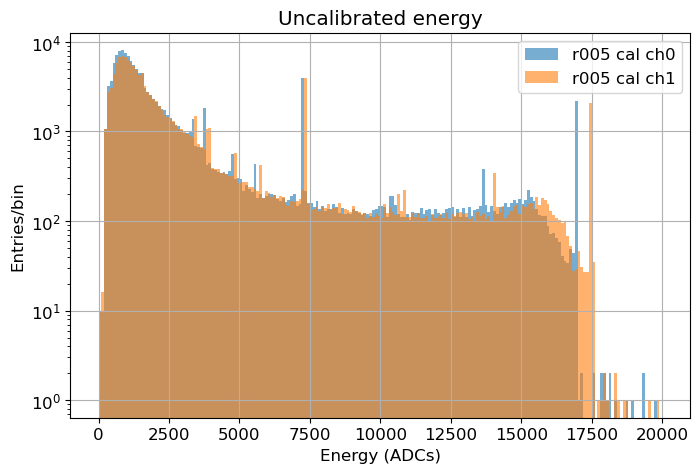

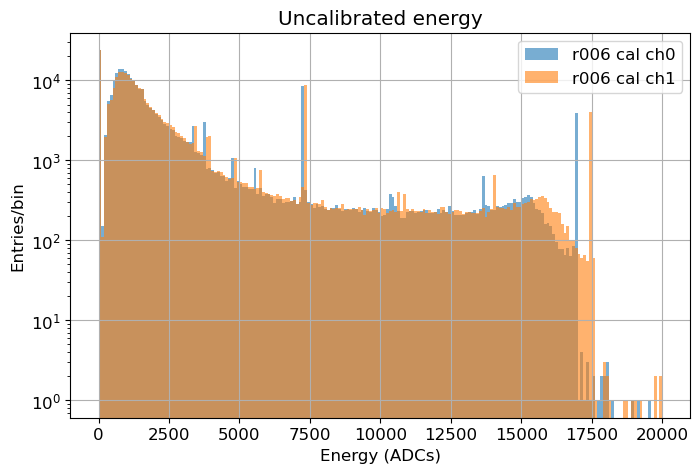

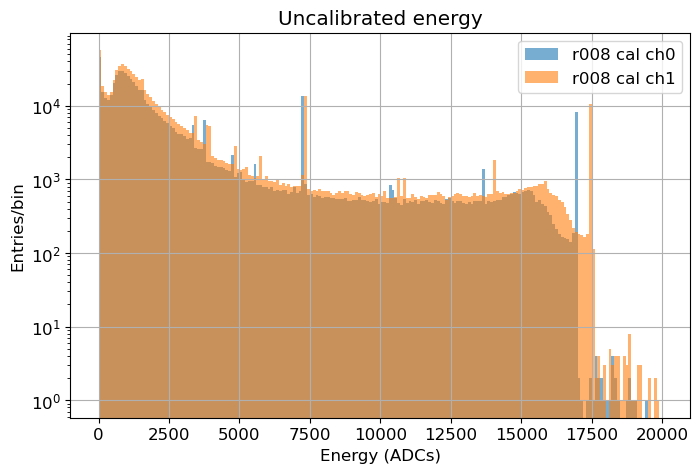

In [10]:
for run in [5, 6, 8]:
    for ch in [0, 1]:
        df_all_dict[dsps(run=run, channel=ch)].trap_max.hist(bins=200, range=(0, 20000), alpha=0.6,
                                                             label=f'r00{run} cal ch{ch}', log=True)
    plt.title('Uncalibrated energy')
    plt.xlabel('Energy (ADCs)')
    plt.ylabel('Entries/bin')
    plt.legend()
    plt.show()

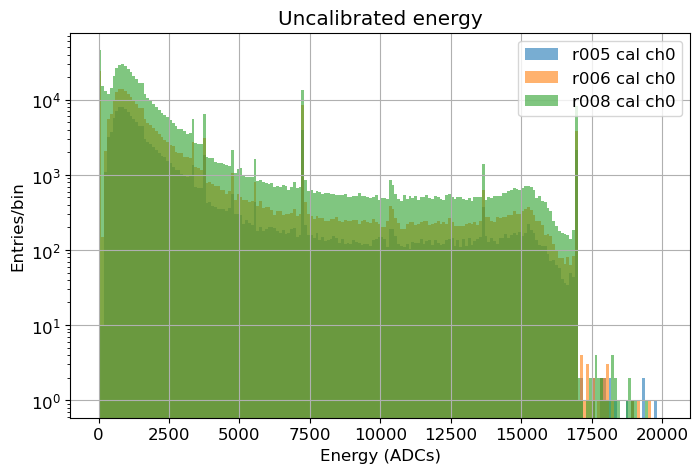

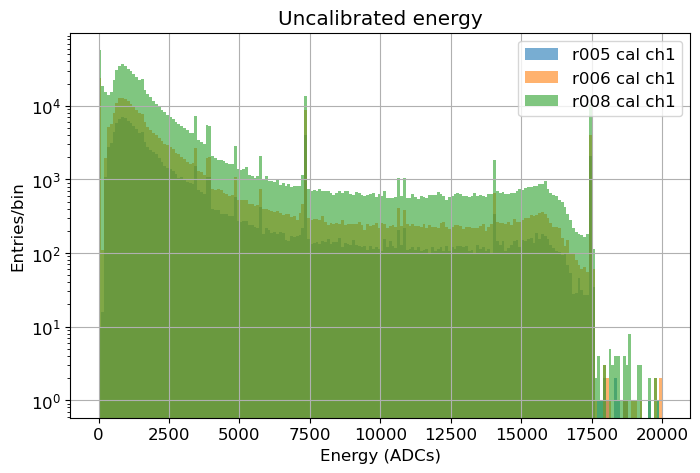

In [11]:
for ch in [0, 1]:
    for run in [5, 6, 8]:
        df_all_dict[dsps(run=run, channel=ch)].trap_max.hist(bins=200, range=(0, 20000), alpha=0.6,
                                                             label=f'r00{run} cal ch{ch}', log=True)
    plt.title('Uncalibrated energy')
    plt.xlabel('Energy (ADCs)')
    plt.ylabel('Entries/bin')
    plt.legend()
    plt.show()

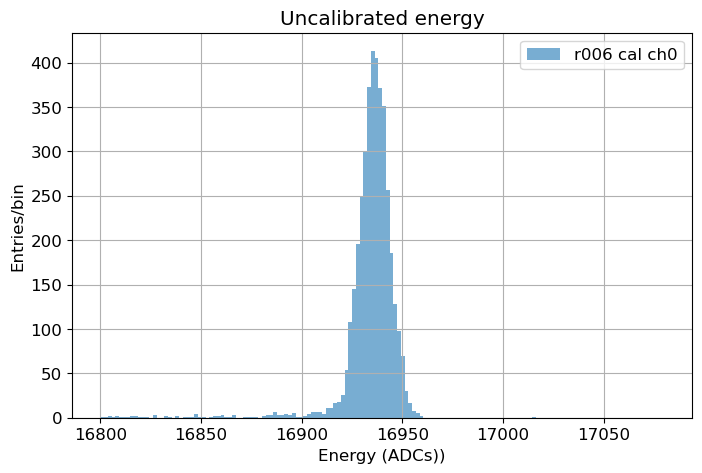

In [12]:
run     = 6
channel = 0
df_all_dict[dsps(run=run, channel=channel)].trap_max.hist(bins=150, range=(16800, 17080), alpha=0.6,
                                                          label=f'r00{run} cal ch{channel}', log=False)
plt.title('Uncalibrated energy')
plt.xlabel('Energy (ADCs))')
plt.ylabel('Entries/bin')
plt.legend()
plt.show()

In [13]:
from scipy.optimize import curve_fit

def shift_to_bin_centers(x):
    """
    Return bin centers, given bin lower edges.
    """
    return x[:-1] + np.diff(x) * 0.5

# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev)**2 / 2)

def gaussian_fit_curve_fit(variable, bins=100, prange=(16800, 17100), ampl=250, mean=16940, sigma=5, frange=(16900, 16970), title='', label=''):

    y, x, _  = plt.hist(variable, 
                        bins=bins, range=prange, alpha=0.6, label=label, log=False)
    
    fit_range_mask = (shift_to_bin_centers(x) >= frange[0]) & (shift_to_bin_centers(x) <= frange[1])
    x_fit_range = shift_to_bin_centers(x)[fit_range_mask]
    y_fit_range = y[fit_range_mask]

    initial_guess = [ampl, mean, sigma]  # Initial guess for amplitude, mean, and standard deviation
    params, covariance = curve_fit(gaussian, x_fit_range, y_fit_range, p0=initial_guess)
    
    # Extract the parameters from the fit
    amplitude_fit, mean_fit, stddev_fit = params
    errors = np.sqrt(np.diag(covariance))
    error_amplitude, error_mean, error_stddev = errors
    
    # Plot the original data and the fitted Gaussian
    plt.scatter(shift_to_bin_centers(x), y)
    fit_label = f'Fit: $\mu$ = {np.round(mean_fit, 1)} ± {np.round(error_mean, 1)} ADCs'
    plt.plot(x, gaussian(x, amplitude_fit, mean_fit, stddev_fit), label=fit_label, color='red')
    plt.title(title)
    plt.xlabel('Energy (ADCs)')
    plt.ylabel('Entries/bin')
    plt.legend()
    plt.show()
    
    return mean_fit, error_mean
    
    
def truncate(number, decimals=0):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

def plot_linear_fit(x, y, yerr):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope*x + intercept
    
    fig = plt.figure(figsize=(8,5))
    plt.errorbar(x, y, yerr=yerr, marker='_', markersize=5, linestyle='', c='k', label=f'Measured gain values')
    plt.plot(x, line, color='r', alpha=0.7, label=f'Fit: y = x*{round(slope, 3)} - {round(np.abs(intercept), 3)}, \n     R$^2$ = {truncate(r_value, 2)}')
    
    plt.xlabel('Energy (keV)')
    plt.ylabel('Mu from fit (ADCs)')
    plt.legend(fontsize=14, loc='upper left')
    plt.show()
    return slope, intercept

## Channel 0 run005

In [14]:
mus_fit     = {}
mus_fit_err = {}

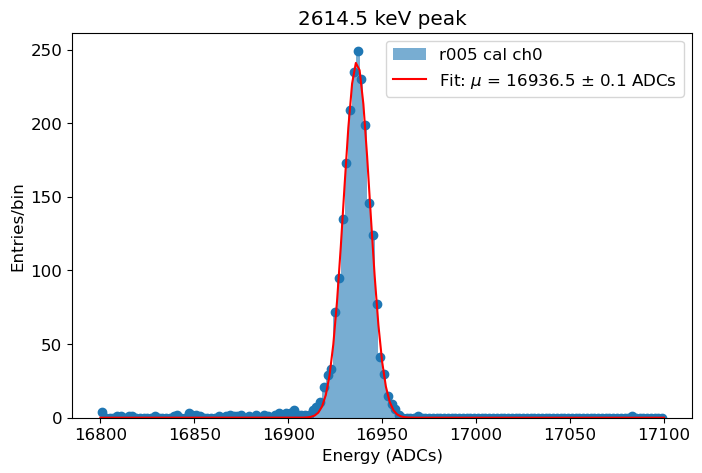

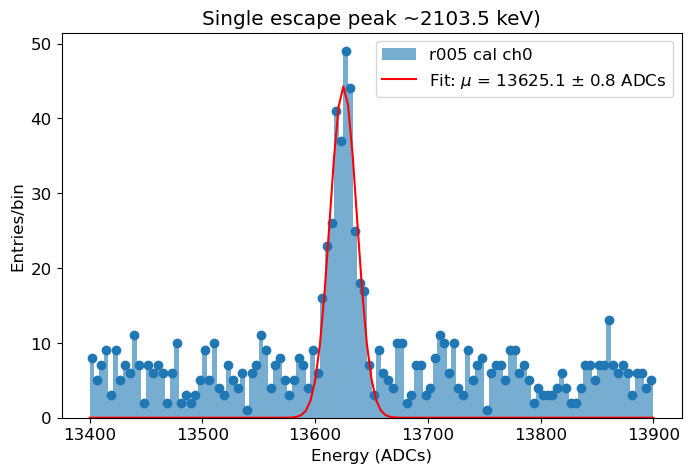

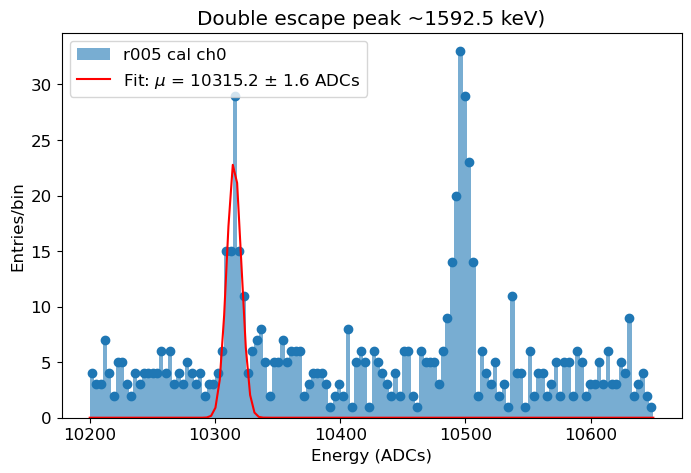

In [15]:
run     = 5
channel = 0
label   = f'r00{run} cal ch{channel}'
data    = df_all_dict[dsps(run=run, channel=channel)]

bins        = [150, 120, 130, 120]
plot_ranges = [(16800, 17100), (13400, 13900), (10200, 10650), (10200, 10650)]
fit_ranges  = [(16900, 16970), (13600, 13650), (10300, 10320), (10480, 10520)]
mus_seed    = [16940, 13620, 10310, 10500]
ampls_seed  = [400, 60, 30, 40]
sigmas_seed = [7, 10, 10, 10]
labels      = ['2614.5 keV peak', 'Single escape peak ~2103.5 keV)',
               'Double escape peak ~1592.5 keV)', 'This is not the Double escape peak']

mus_fit_conf     = []
mus_fit_conf_err = []

for i, (bns,pr,mu,sig,ampl,fr,title) in enumerate(zip(bins, plot_ranges, mus_seed, sigmas_seed, 
                                                      ampls_seed, fit_ranges, labels)):
    if i < 3:
        mu_peak, mu_peak_err = gaussian_fit_curve_fit(data.trap_max, bins=bns, prange=pr,
                                                        ampl=ampl, mean=mu, sigma=sig, frange=fr,
                                                        title=title, label=label)
        mus_fit_conf    .append(mu_peak)
        mus_fit_conf_err.append(mu_peak_err)
    
mus_fit    [dsps(run=run, channel=channel)] = np.array(mus_fit_conf)
mus_fit_err[dsps(run=run, channel=channel)] = np.array(mus_fit_conf_err)

## Linear fits for the 3 lines:

In [16]:
cal_const = {}

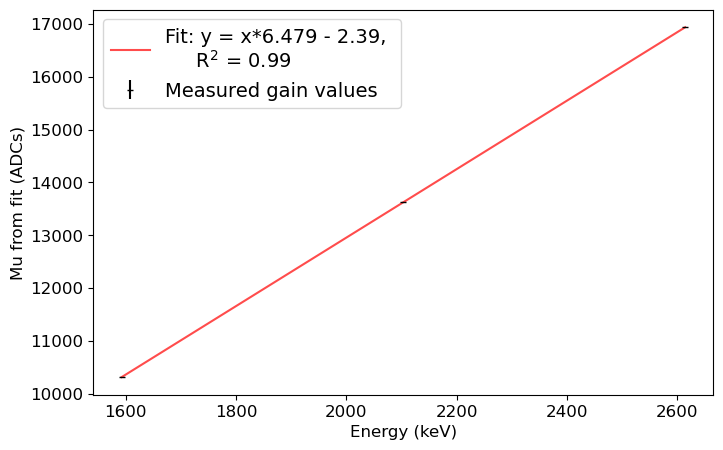

In [17]:
energies = np.array([2614.5, 2103.5, 1592.5])

run     = 5
channel = 0

slope, interc = plot_linear_fit(energies, mus_fit    [dsps(run=run, channel=channel)], 
                                          mus_fit_err[dsps(run=run, channel=channel)])
cal_const[dsps(run=run, channel=channel)] = (slope, interc)

## Channel 0 run006

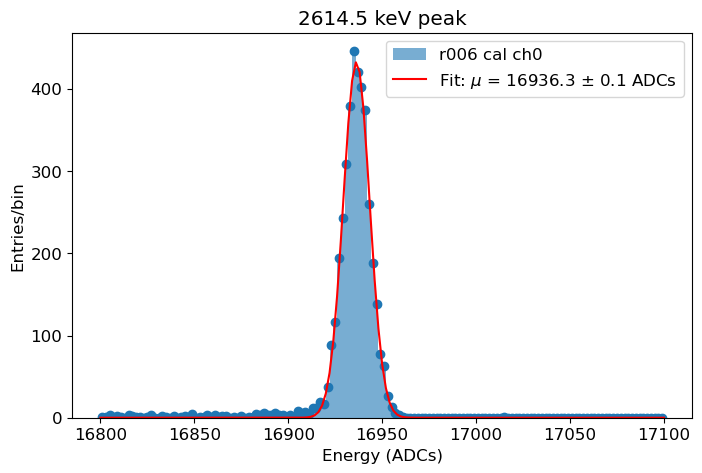

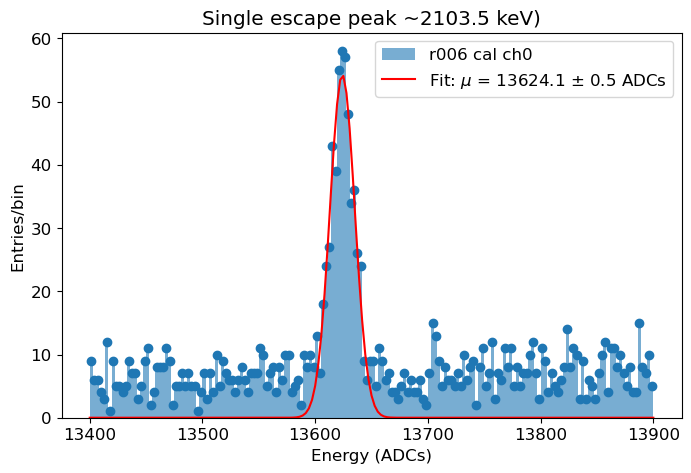

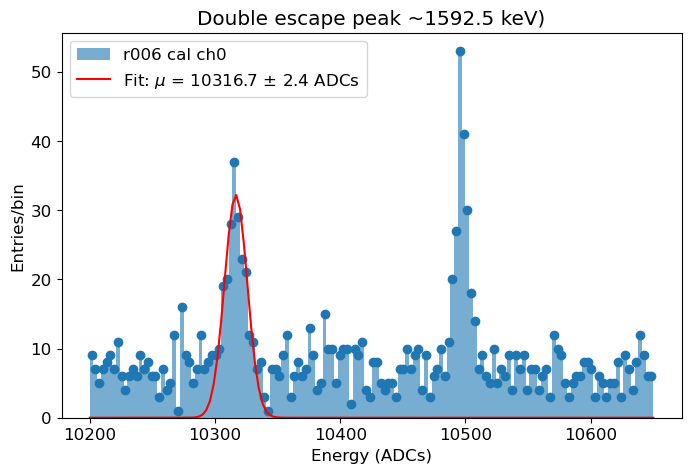

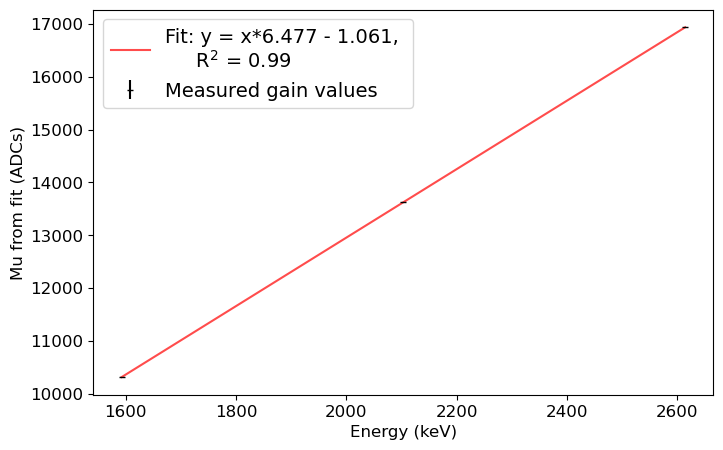

In [18]:
run     = 6
channel = 0
label   = f'r00{run} cal ch{channel}'
data    = df_all_dict[dsps(run=run, channel=channel)]

bins        = [150, 180, 150, 150]
plot_ranges = [(16800, 17100), (13400, 13900), (10200, 10650), (10200, 10650)]
fit_ranges  = [(16900, 16970), (13600, 13650), (10300, 10320), (10480, 10520)]
mus_seed    = [16940, 13620, 10310, 10500]
ampls_seed  = [400, 60, 30, 40]
sigmas_seed = [7, 10, 10, 10]
labels      = ['2614.5 keV peak', 'Single escape peak ~2103.5 keV)',
               'Double escape peak ~1592.5 keV)', 'This is not the Double escape peak']

mus_fit_conf     = []
mus_fit_conf_err = []

for i, (bns,pr,mu,sig,ampl,fr,title) in enumerate(zip(bins, plot_ranges, mus_seed, sigmas_seed, 
                                                      ampls_seed, fit_ranges, labels)):
    if i < 3:
        mu_peak, mu_peak_err = gaussian_fit_curve_fit(data.trap_max, bins=bns, prange=pr,
                                                        ampl=ampl, mean=mu, sigma=sig, frange=fr,
                                                        title=title, label=label)
        mus_fit_conf    .append(mu_peak)
        mus_fit_conf_err.append(mu_peak_err)
    
mus_fit    [dsps(run=run, channel=channel)] = np.array(mus_fit_conf)
mus_fit_err[dsps(run=run, channel=channel)] = np.array(mus_fit_conf_err)

slope, interc = plot_linear_fit(energies, mus_fit    [dsps(run=run, channel=channel)], 
                                          mus_fit_err[dsps(run=run, channel=channel)])
cal_const[dsps(run=run, channel=channel)] = (slope, interc)

## Channel 0 run008

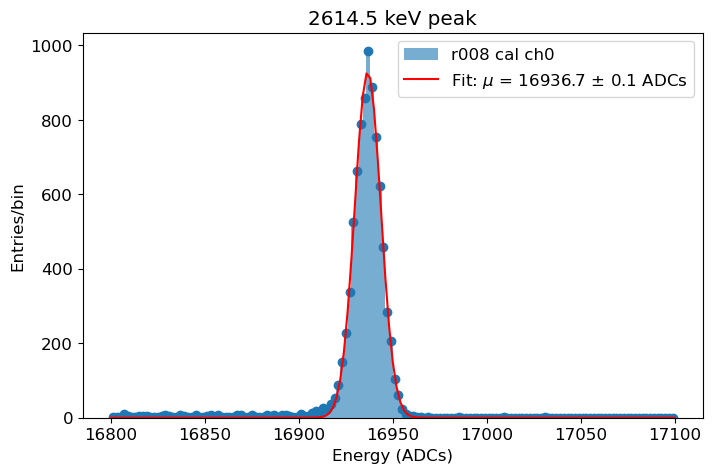

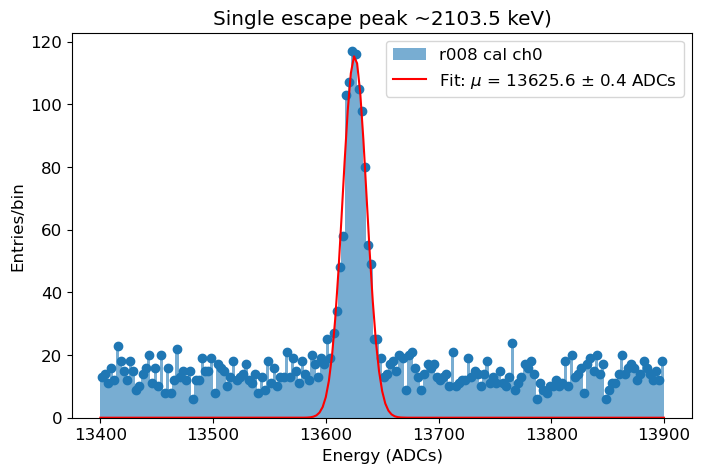

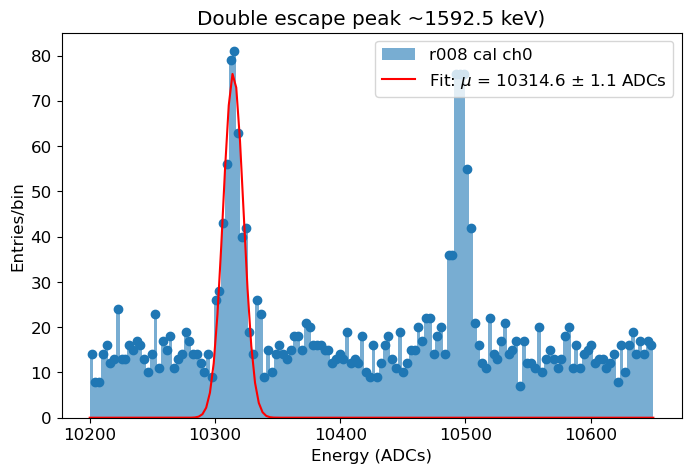

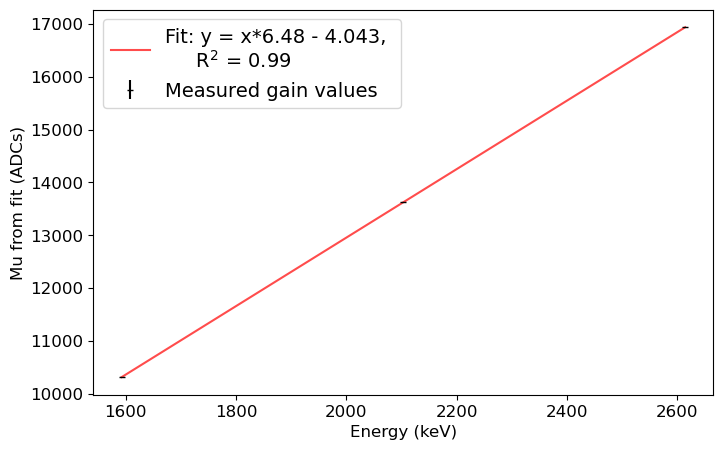

In [19]:
run     = 8
channel = 0
label   = f'r00{run} cal ch{channel}'
data    = df_all_dict[dsps(run=run, channel=channel)]

bins        = [150, 180, 150, 150]
plot_ranges = [(16800, 17100), (13400, 13900), (10200, 10650), (10200, 10650)]
fit_ranges  = [(16900, 16970), (13600, 13650), (10300, 10320), (10480, 10520)]
mus_seed    = [16940, 13620, 10310, 10500]
sigmas_seed = [7, 10, 8, 10]
ampls_seed  = [900, 100, 80, 100]

mus_fit_conf     = []
mus_fit_conf_err = []

for i, (bns,pr,mu,sig,ampl,fr,title) in enumerate(zip(bins, plot_ranges, mus_seed, sigmas_seed, 
                                                      ampls_seed, fit_ranges, labels)):
    if i < 3:
        mu_peak, mu_peak_err = gaussian_fit_curve_fit(data.trap_max, bins=bns, prange=pr,
                                                        ampl=ampl, mean=mu, sigma=sig, frange=fr,
                                                        title=title, label=label)
        mus_fit_conf    .append(mu_peak)
        mus_fit_conf_err.append(mu_peak_err)
    
mus_fit    [dsps(run=run, channel=channel)] = np.array(mus_fit_conf)
mus_fit_err[dsps(run=run, channel=channel)] = np.array(mus_fit_conf_err)

slope, interc = plot_linear_fit(energies, mus_fit    [dsps(run=run, channel=channel)], 
                                          mus_fit_err[dsps(run=run, channel=channel)])
cal_const[dsps(run=run, channel=channel)] = (slope, interc)

## Channel 1 r005

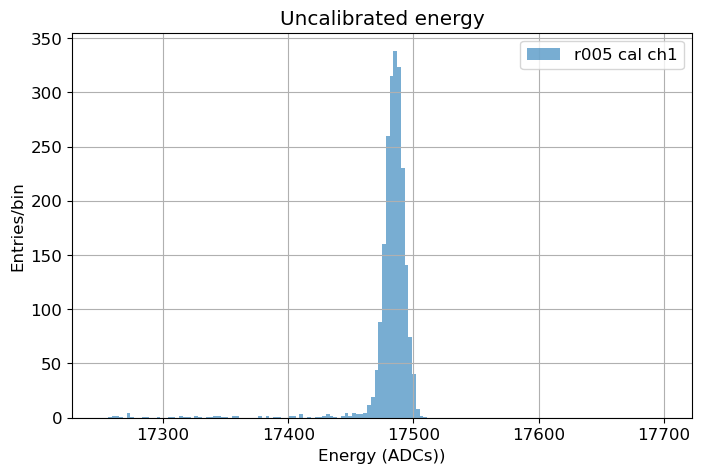

In [20]:
run     = 5
channel = 1
df_all_dict[dsps(run=run, channel=channel)].trap_max.hist(bins=150, range=(17250, 17700), alpha=0.6,
                                                          label=f'r00{run} cal ch{channel}', log=False)
plt.title('Uncalibrated energy')
plt.xlabel('Energy (ADCs))')
plt.ylabel('Entries/bin')
plt.legend()
plt.show()

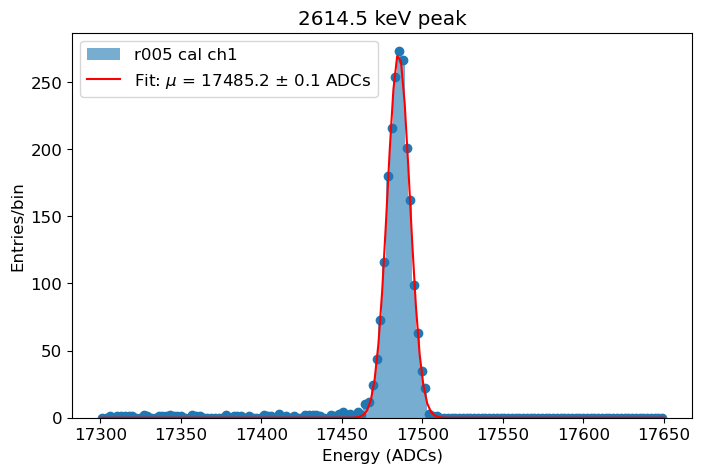

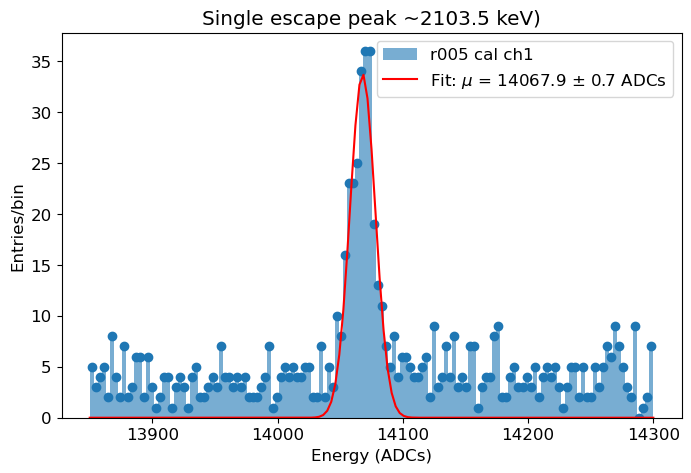

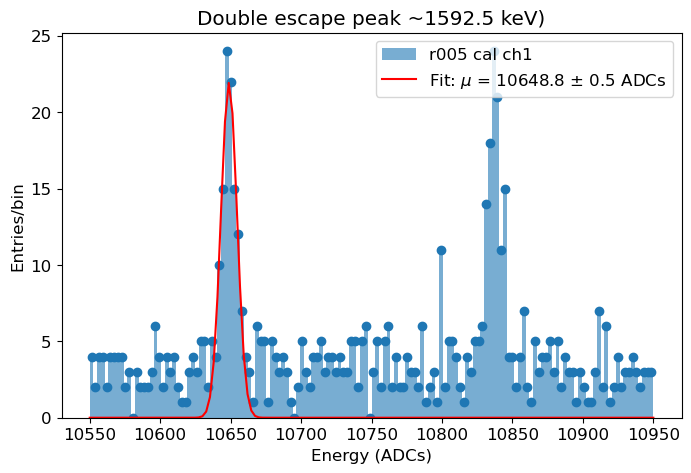

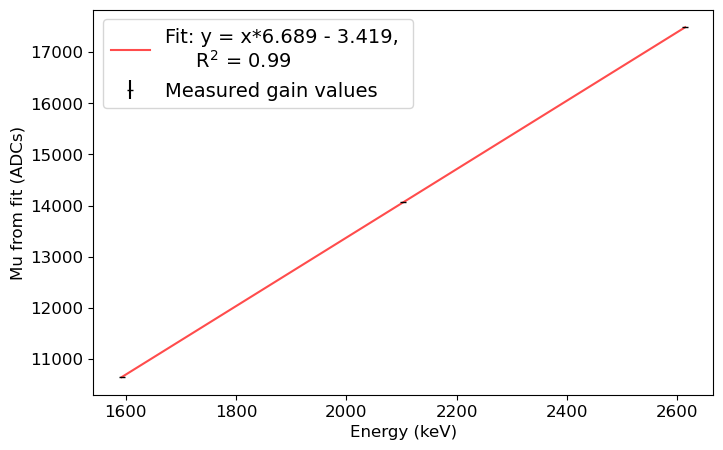

In [21]:
run     = 5
channel = 1
label   = f'r00{run} cal ch{channel}'
data    = df_all_dict[dsps(run=run, channel=channel)]

bins        = [150, 140, 150, 150]
plot_ranges = [(17300, 17650), (13850, 14300), (10550, 10950), (10550, 10950)]
fit_ranges  = [(17470, 17500), (14050, 14090), (10630, 10660), (10830, 10850)]
mus_seed    = [17490, 14070, 10650, 10840]
sigmas_seed = [7, 10, 8, 10]
ampls_seed  = [500, 70, 40, 30]

mus_fit_conf     = []
mus_fit_conf_err = []

for i, (bns,pr,mu,sig,ampl,fr,title) in enumerate(zip(bins, plot_ranges, mus_seed, sigmas_seed, 
                                                      ampls_seed, fit_ranges, labels)):
    if i < 3:
        mu_peak, mu_peak_err = gaussian_fit_curve_fit(data.trap_max, bins=bns, prange=pr,
                                                      ampl=ampl, mean=mu, sigma=sig, frange=fr,
                                                      title=title, label=label)
        mus_fit_conf    .append(mu_peak)
        mus_fit_conf_err.append(mu_peak_err)
    
mus_fit    [dsps(run=run, channel=channel)] = np.array(mus_fit_conf)
mus_fit_err[dsps(run=run, channel=channel)] = np.array(mus_fit_conf_err)

slope, interc = plot_linear_fit(energies, mus_fit    [dsps(run=run, channel=channel)], 
                                          mus_fit_err[dsps(run=run, channel=channel)])
cal_const[dsps(run=run, channel=channel)] = (slope, interc)

## Channel 1 r006

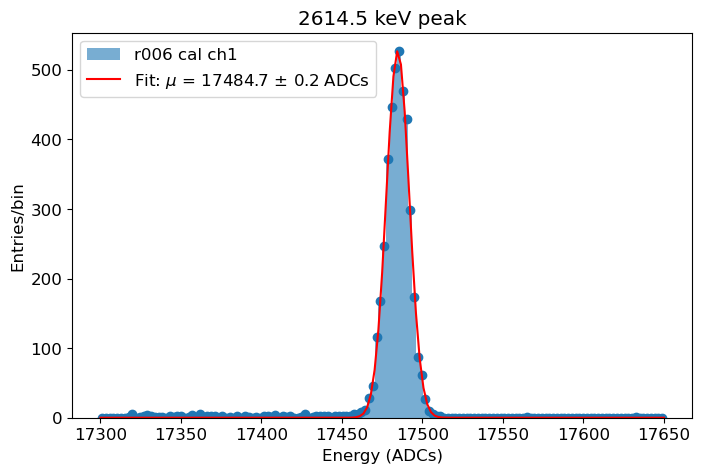

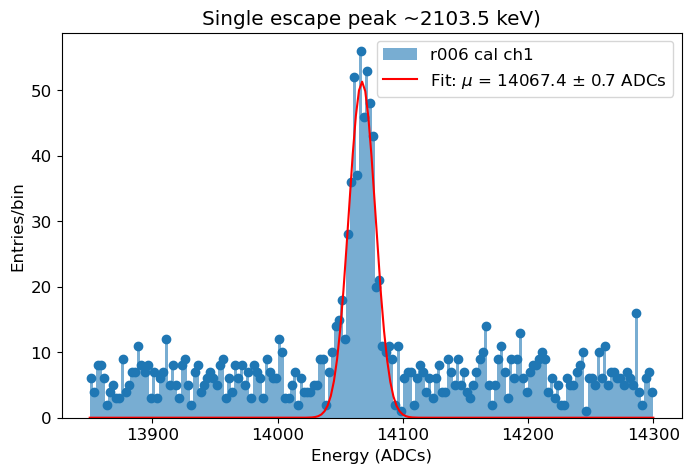

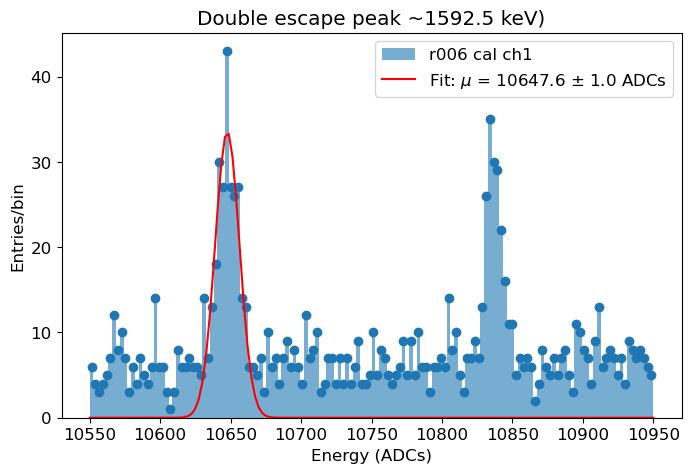

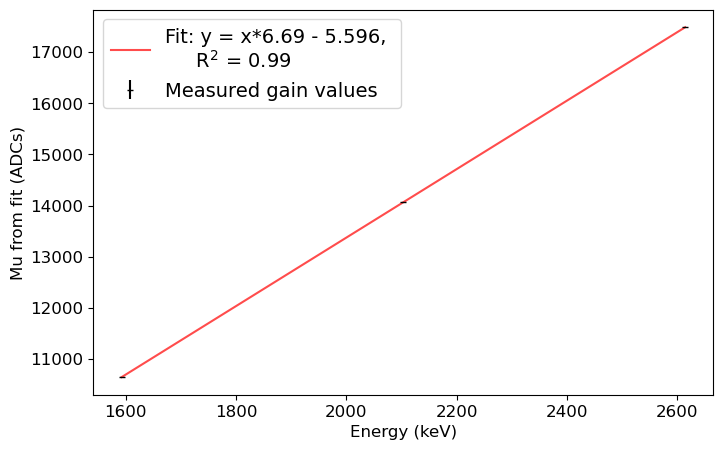

In [22]:
run     = 6
channel = 1
label   = f'r00{run} cal ch{channel}'
data    = df_all_dict[dsps(run=run, channel=channel)]

bins        = [150, 180, 150, 150]
plot_ranges = [(17300, 17650), (13850, 14300), (10550, 10950), (10550, 10950)]
fit_ranges  = [(17470, 17500), (14040, 14090), (10630, 10660), (10830, 10850)]
mus_seed    = [17490, 14090, 10650, 10840]
sigmas_seed = [7, 10, 8, 10]
ampls_seed  = [500, 70, 40, 30]

mus_fit_conf     = []
mus_fit_conf_err = []

for i, (bns,pr,mu,sig,ampl,fr,title) in enumerate(zip(bins, plot_ranges, mus_seed, sigmas_seed, 
                                                      ampls_seed, fit_ranges, labels)):
    if i < 3:
        mu_peak, mu_peak_err = gaussian_fit_curve_fit(data.trap_max, bins=bns, prange=pr,
                                                      ampl=ampl, mean=mu, sigma=sig, frange=fr,
                                                      title=title, label=label)
        mus_fit_conf    .append(mu_peak)
        mus_fit_conf_err.append(mu_peak_err)
    
mus_fit    [dsps(run=run, channel=channel)] = np.array(mus_fit_conf)
mus_fit_err[dsps(run=run, channel=channel)] = np.array(mus_fit_conf_err)

slope, interc = plot_linear_fit(energies, mus_fit    [dsps(run=run, channel=channel)], 
                                          mus_fit_err[dsps(run=run, channel=channel)])
cal_const[dsps(run=run, channel=channel)] = (slope, interc)

## Channel 1 r008

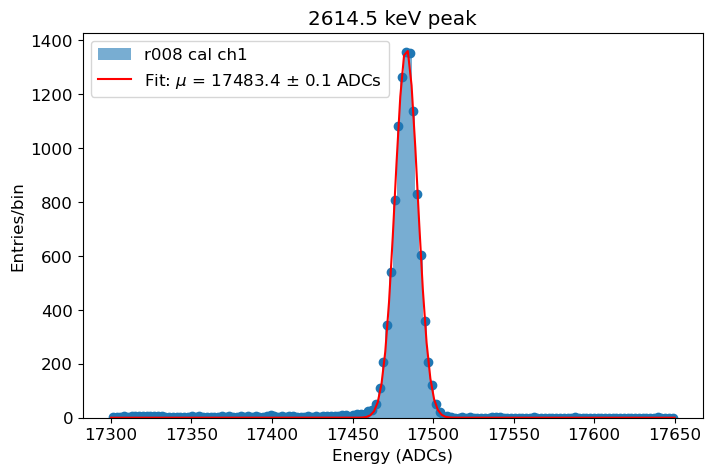

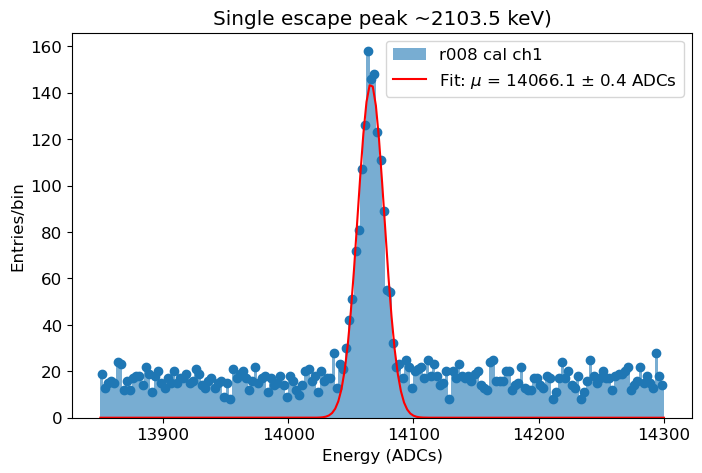

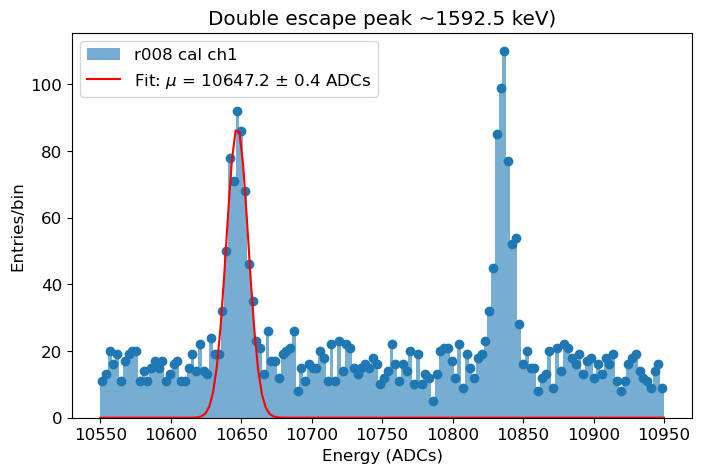

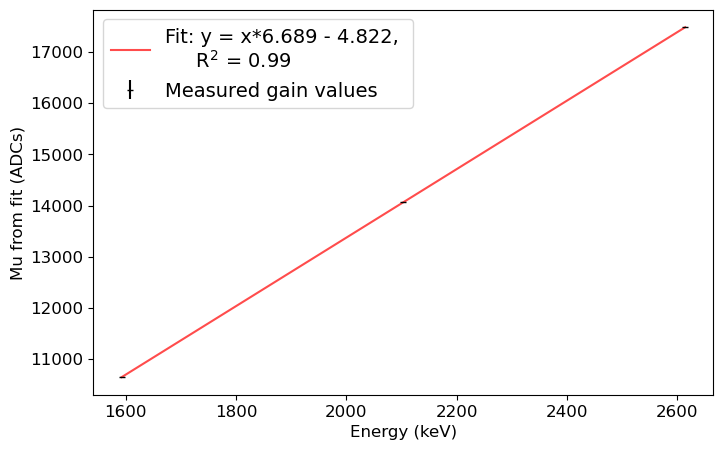

In [23]:
run     = 8
channel = 1
label   = f'r00{run} cal ch{channel}'
data    = df_all_dict[dsps(run=run, channel=channel)]

bins        = [150, 180, 150, 150]
plot_ranges = [(17300, 17650), (13850, 14300), (10550, 10950), (10550, 10950)]
fit_ranges  = [(17470, 17500), (14040, 14100), (10630, 10660), (10830, 10850)]
mus_seed    = [17490, 14090, 10650, 10840]
sigmas_seed = [7, 10, 8, 10]
ampls_seed  = [1300, 160, 90, 110]

mus_fit_conf     = []
mus_fit_conf_err = []

for i, (bns,pr,mu,sig,ampl,fr,title) in enumerate(zip(bins, plot_ranges, mus_seed, sigmas_seed, 
                                                      ampls_seed, fit_ranges, labels)):
    if i < 3:
        mu_peak, mu_peak_err = gaussian_fit_curve_fit(data.trap_max, bins=bns, prange=pr,
                                                      ampl=ampl, mean=mu, sigma=sig, frange=fr,
                                                      title=title, label=label)
        mus_fit_conf    .append(mu_peak)
        mus_fit_conf_err.append(mu_peak_err)
    
mus_fit    [dsps(run=run, channel=channel)] = np.array(mus_fit_conf)
mus_fit_err[dsps(run=run, channel=channel)] = np.array(mus_fit_conf_err)

slope, interc = plot_linear_fit(energies, mus_fit    [dsps(run=run, channel=channel)], 
                                          mus_fit_err[dsps(run=run, channel=channel)])
cal_const[dsps(run=run, channel=channel)] = (slope, interc)

In [24]:
cal_const

{dsps(run=5, channel=0): (6.47872002988613, -2.390156533449044),
 dsps(run=6, channel=0): (6.477131358876935, 1.0614262603903626),
 dsps(run=8, channel=0): (6.479518798766513, -4.043124672109116),
 dsps(run=5, channel=1): (6.6891971468237585, -3.4191338069485937),
 dsps(run=6, channel=1): (6.689891664655627, -5.595979709461972),
 dsps(run=8, channel=1): (6.689036744259721, -4.821797502285335)}

# Spectra calibrated

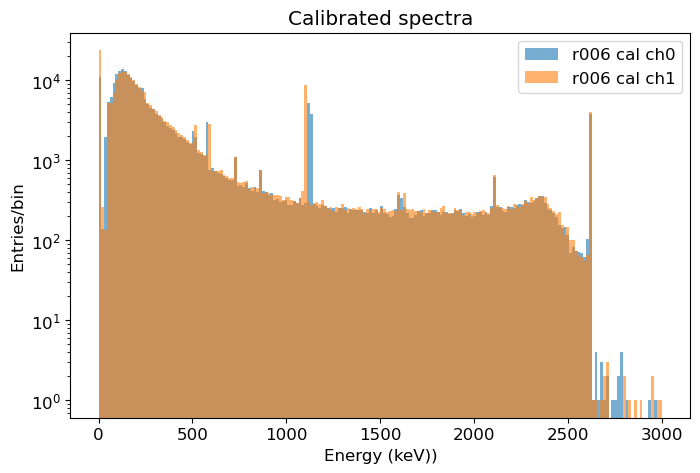

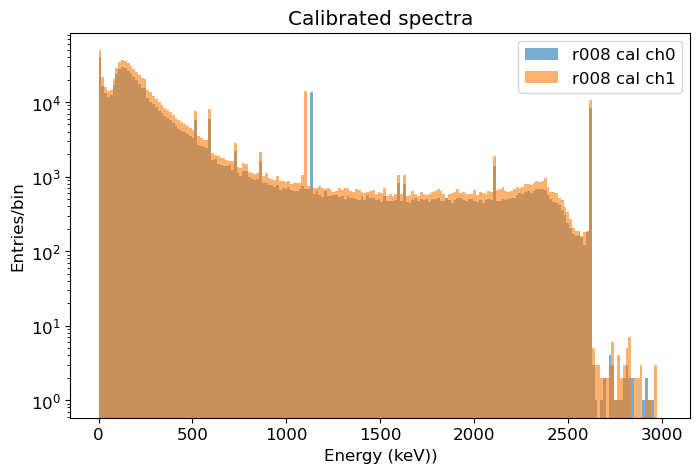

In [25]:
for run in [6, 8]:
    for ch in [0, 1]:
        data   = df_all_dict[dsps(run=run, channel=ch)]
        slope  = cal_const  [dsps(run=run, channel=ch)][0]
        interc = cal_const  [dsps(run=run, channel=ch)][1]
        plt.hist((data.trap_max/slope) - interc, bins=200, range=(0, 3000), alpha=0.6,
                 label=f'r00{run} cal ch{ch}', log=True)
    plt.title('Calibrated spectra')
    plt.xlabel('Energy (keV))')
    plt.ylabel('Entries/bin')
    plt.legend()
    plt.show()

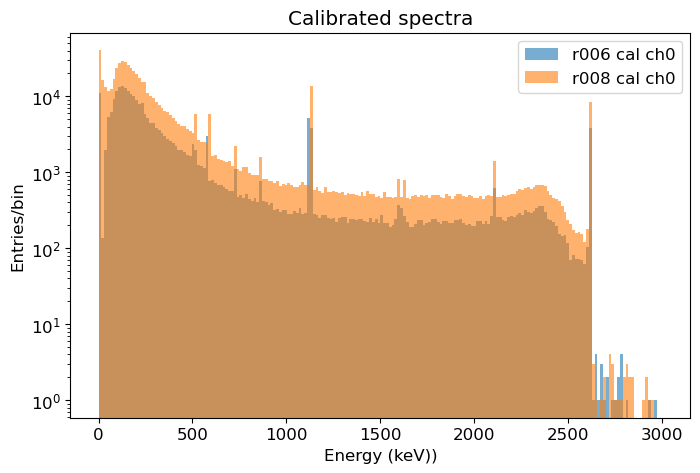

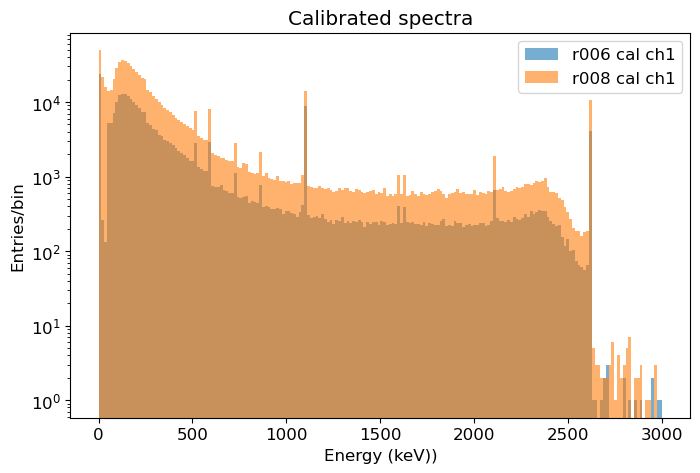

In [26]:
for ch in [0, 1]:
    for run in [6, 8]:
        data   = df_all_dict[dsps(run=run, channel=ch)]
        slope  = cal_const  [dsps(run=run, channel=ch)][0]
        interc = cal_const  [dsps(run=run, channel=ch)][1]
        plt.hist((data.trap_max/slope) - interc, bins=200, range=(0, 3000), alpha=0.6,
                 label=f'r00{run} cal ch{ch}', log=True)
    plt.title('Calibrated spectra')
    plt.xlabel('Energy (keV))')
    plt.ylabel('Entries/bin')
    plt.legend()
    plt.show()

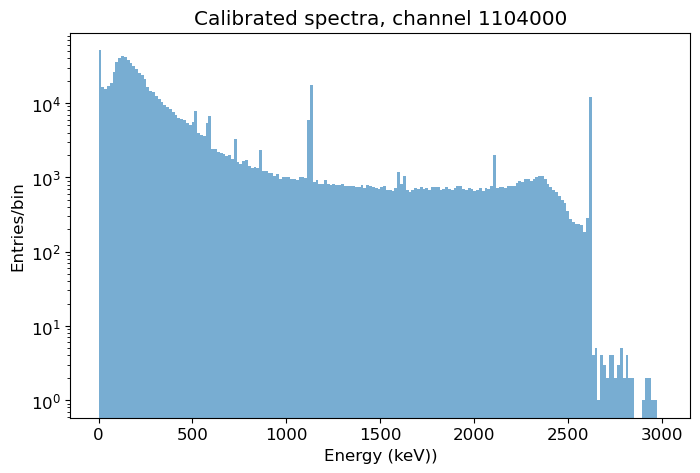

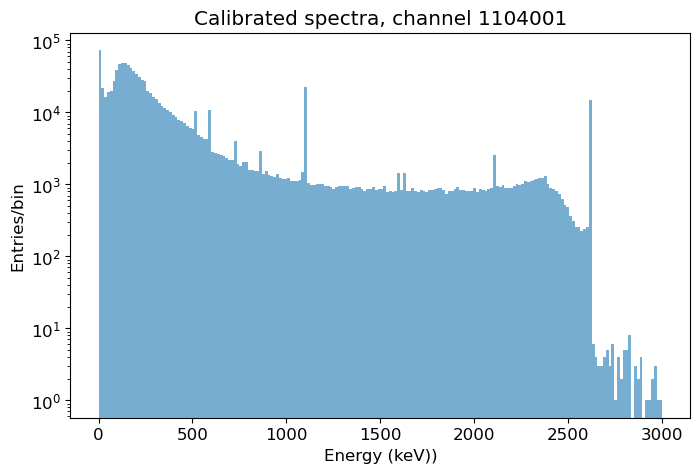

In [27]:
for ch in [0, 1]:
    all_specs = np.concatenate([(df_all_dict[dsps(run=run, channel=ch)].trap_max/cal_const[dsps(run=run, channel=ch)][0]) - cal_const[dsps(run=run, channel=ch)][1]
                               for run in [6, 8]])

    plt.hist(all_specs, bins=200, range=(0, 3000), alpha=0.6, log=True)
    plt.title(f'Calibrated spectra, channel 110400{ch}')
    plt.xlabel('Energy (keV))')
    plt.ylabel('Entries/bin')
    #plt.legend()
    plt.show()

In [28]:
cal_const

{dsps(run=5, channel=0): (6.47872002988613, -2.390156533449044),
 dsps(run=6, channel=0): (6.477131358876935, 1.0614262603903626),
 dsps(run=8, channel=0): (6.479518798766513, -4.043124672109116),
 dsps(run=5, channel=1): (6.6891971468237585, -3.4191338069485937),
 dsps(run=6, channel=1): (6.689891664655627, -5.595979709461972),
 dsps(run=8, channel=1): (6.689036744259721, -4.821797502285335)}

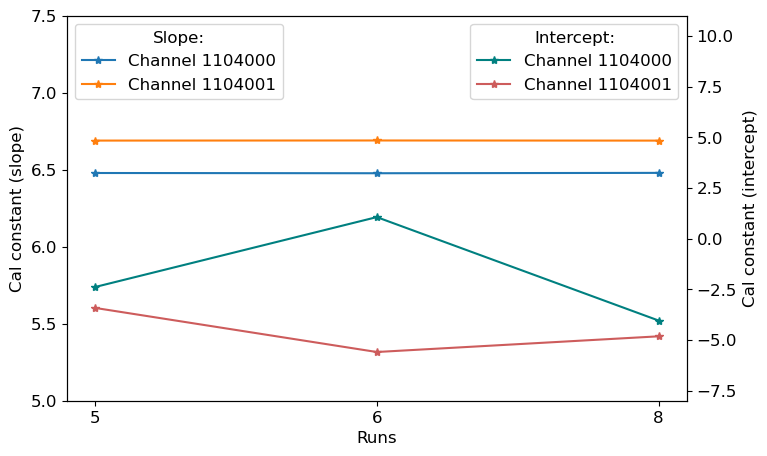

In [29]:
fig, ax0 = plt.subplots(1, 1, figsize=(8,5))
ax1 = ax0.twinx()
for ch, col2 in zip([0, 1], ['teal', 'indianred']):
    ax0.plot([cal_const[dsps(run=run, channel=ch)][0] for run in [5,6,8]], marker='*', label=f'Channel 110400{ch}')
    ax1.plot([cal_const[dsps(run=run, channel=ch)][1] for run in [5,6,8]], marker='*', label=f'Channel 110400{ch}', color=col2)
ax0.set_ylim(5, 7.5)
ax1.set_ylim(-8, 11)
ax0.set_xticks([0, 1, 2], [5, 6, 8])
ax0.set_xlabel('Runs')
ax0.set_ylabel('Cal constant (slope)')
ax1.set_ylabel('Cal constant (intercept)')
ax0.legend(title='Slope:',     loc=2)
ax1.legend(title='Intercept:', loc=0)
plt.show()